In [1]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_project"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/My Drive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
% cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1uHceact8nZzLehIO7J8WmUhJnJWKOf8w/Final_project


# Downgrade opencv

In [2]:
import cv2
if cv2.__version__[0] == '4':
    !pip uninstall opencv-python -y
    #downgrade OpenCV a bit since some none-free features are not avilable
    !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [3]:
from src.loadData import loadFer2013
from keras.utils import to_categorical

In [4]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

/content/drive/.shortcut-targets-by-id/1uHceact8nZzLehIO7J8WmUhJnJWKOf8w/Final_project/src/loadData.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emotion'][data['emotion']>1]-=1


In [5]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((28709, 6), (3589, 6), (3589, 6))

In [6]:
X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

In [7]:
emotions = {0: 'Angry', 1:'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [8]:
class_names = list(emotions.values())
class_names

['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Extract features

In [11]:
from src.extractFeatures import *

In [12]:

X_descriptors_train = extract_sift_features(X_train)
X_descriptors_val = extract_sift_features(X_val)
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(X_descriptors_train[i])))

Image 0 has 24 descriptors
Image 1 has 36 descriptors
Image 2 has 25 descriptors
Image 3 has 26 descriptors
Image 4 has 27 descriptors
Image 5 has 25 descriptors
Image 6 has 23 descriptors
Image 7 has 20 descriptors
Image 8 has 25 descriptors
Image 9 has 26 descriptors


In [13]:
import time
num_clusters = 150
X_descriptors = X_descriptors_train+X_descriptors_val
print(len(X_descriptors))
st = time.time()
bow_dict = create_BoWSIFTfeature(X_descriptors,num_clusters)
en = time.time()
print("time",en-st)
X_features = create_features_bow(X_descriptors, bow_dict, num_clusters)

32298
Done load available result
time 0.14299893379211426


In [14]:
len(X_features)

32298

# Random Forest Classification

In [15]:
from sklearn.ensemble import RandomForestClassifier

y_label = np.hstack((y_train,y_val))
y_label.shape

(32298,)

In [19]:
import time
RF = RandomForestClassifier(max_depth=20, random_state=0)
st = time.time()
RF.fit(X_features, y_label)
print(time.time()-st)


6.30351710319519


In [17]:
RF.score(X_features, y_label)

0.9031518979503375

In [18]:
import pickle
pickle.dump(RF, open('saved_model/sift150_RFd20.pkl', 'wb'))

#Evaluation

In [20]:
import pickle

num_clusters = 150
bow_dict = pickle.load(open('BoW_data/bow_dict_{}.pkl'.format(num_clusters), 'rb'))

X_descriptors_test = extract_sift_features(X_test)
X_features_test = create_features_bow(X_descriptors_test, bow_dict,num_clusters )
y_pred = RF.predict(X_features_test)

print(RF.score(X_features_test,y_test))

0.34912231819448314


In [21]:
from sklearn import metrics

metrics.f1_score(y_test,y_pred,average='micro')

0.34912231819448314

# Visual

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efff159ff28>)

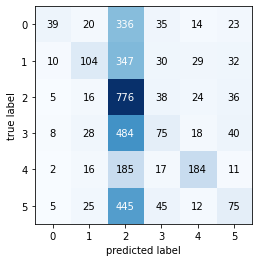

In [22]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix(y_test,y_pred))

In [23]:
from sklearn.metrics import classification_report
from src.visualization import plot_classification_report

clf_report = classification_report(y_test, y_pred, digits=4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.5652    0.0835    0.1455       467
           1     0.4976    0.1884    0.2733       552
           2     0.3016    0.8670    0.4475       895
           3     0.3125    0.1149    0.1680       653
           4     0.6548    0.4434    0.5287       415
           5     0.3456    0.1236    0.1820       607

    accuracy                         0.3491      3589
   macro avg     0.4462    0.3035    0.2909      3589
weighted avg     0.4163    0.3491    0.2951      3589



In [24]:
import pandas as pd
df = pd.DataFrame(classification_report(y_test, y_pred, digits=1,output_dict=True)).T

df['support'] = df.support.apply(int)

df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'6', :'f1-score'])

,precision,recall,f1-score,support
0,0.565217,0.083512,0.145522,467
1,0.497608,0.188406,0.273325,552
2,0.301593,0.867039,0.447520,895
3,0.312500,0.114855,0.167973,653
4,0.654804,0.443373,0.528736,415
5,0.345622,0.123558,0.182039,607
accuracy,0.349122,0.349122,0.349122,0
macro avg,0.446224,0.303457,0.290852,3589
weighted avg,0.416317,0.349122,0.295061,3589
